In [1]:
import logging
import json
import os
import re
from typing import Optional, List

import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import wandb
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, BatchSampler
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness
from timm import create_model
from einops import rearrange, reduce
from skimage.color import label2rgb
from skimage.measure import regionprops_table

In [2]:
wandb.login() 

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

#### load annotations

In [3]:
# a = sc.read_h5ad('../data/pdac/HT270P1-S1H1U1/adata.h5ad')
a = sc.read_h5ad('../data/annotations/pdac/HT270P1-S1H1U1.h5ad')
a

AnnData object with n_obs × n_vars = 3940 × 12
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '2X_trimmed_exp_prediction', '2X_trimmed_meta_prediction', 'full_res_he', 'genes', 'hvg', 'leiden', 'log1p', 'neighbors', 'nuclei_segmentation_1X_notrim', 'nuclei_segmentation_1X_trimmed', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'segmented_nuclei_coords', 'segmented_nuclei_coords_1X_notrim', 'segmented_nuclei_coords_1X_trimmed', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

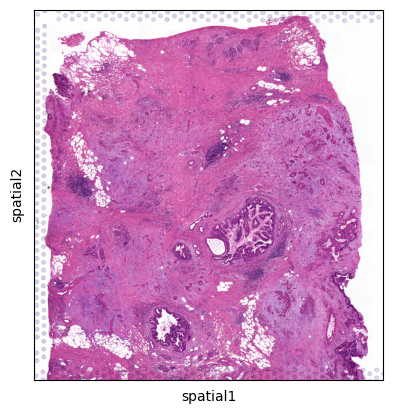

In [4]:
sc.pl.spatial(a)

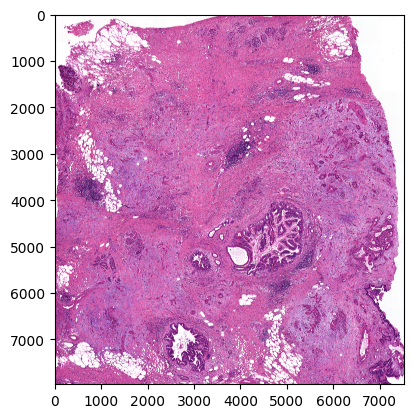

In [5]:
plt.imshow(a.uns['rescaled_he']['2X_trimmed'])

In [6]:
# import tifffile
# tifffile.imwrite('../data/annotations/pdac/HT270P1-S1H1U1_1X_trimmed.tiff', a.uns['rescaled_he']['1X_trimmed'])

In [7]:
scale = 2 # scale from full_res

In [8]:
ls = json.load(open('../data/annotations/pdac/HT270P1-S1H1U1_1X_trimmed.geojson'))['features']
label_to_pts = {}
for d in ls:
    coords = np.asarray(d['geometry']['coordinates']) // scale
    label = d['properties']['classification']['name']
    label_to_pts[label] = np.asarray(coords, dtype=np.int32)
label_to_pts

{'Islet': array([[4370,  574],
        [4392,  580],
        [4395,  558],
        [4418,  611],
        [4377,  690],
        [4377,  697],
        [4309,  636],
        [4288,  634],
        [4263,  678],
        [4328,  713],
        [4329,  701],
        [4311,  673],
        [4198,  642],
        [4198,  620],
        [4179,  644],
        [4168,  705],
        [4140,  680],
        [4165,  682],
        [4129,  635],
        [4139,  617],
        [4122,  604],
        [4100,  587],
        [4085,  611],
        [4095,  652],
        [4160,  570],
        [3780,  445],
        [3780,  461],
        [3815,  494],
        [3761,  556],
        [3734,  475],
        [3734,  453],
        [3844,  411],
        [3856,  426],
        [3792,  402],
        [3765,  392],
        [3775,  388],
        [3384,  366],
        [3424,  379],
        [3401,  386],
        [3446,  400],
        [3448,  353],
        [3356,  330],
        [3325,  349],
        [3353,  400],
        [3353,  436],
 

In [9]:
data = []
labels = sorted(label_to_pts.keys())
for label, pts in label_to_pts.items():
    for c, r in pts:
        data.append([r, c, label, labels.index(label)])
coord_df = pd.DataFrame(data=data, columns=['row', 'col', 'label', 'label_idx'])
coord_df

row   col         label  label_idx
0      574  4370         Islet          5
1      580  4392         Islet          5
2      558  4395         Islet          5
3      611  4418         Islet          5
4      690  4377         Islet          5
...    ...   ...           ...        ...
1577  4940  5480  Immune cells          4
1578  4932  5455  Immune cells          4
1579  4376  5470  Immune cells          4
1580  4476  5529  Immune cells          4
1581  4462  5443  Immune cells          4

[1582 rows x 4 columns]

In [10]:
def reflection_mosiac(x, border=256):
    max_r, max_c = x.shape[-2], x.shape[-1]
    mosaic = torch.zeros((x.shape[0], max_r + (border * 2), max_c + (border * 2)), dtype=x.dtype)
    
    # make tiles
    top_left = TF.pad(x, padding=[border, border, 0, 0], padding_mode='reflect')
    top_right = TF.pad(x, padding=[0, border, border, 0], padding_mode='reflect')
    bottom_left = TF.pad(x, padding=[border, 0, 0, border], padding_mode='reflect')
    bottom_right = TF.pad(x, padding=[0, 0, border, border], padding_mode='reflect')
    
    mosaic[:, :max_r + border, :max_c + border] = top_left
    mosaic[:, :max_r + border, border:] = top_right
    mosaic[:, border:, :max_c + border] = bottom_left
    mosaic[:, border:, border:] = bottom_right
    
    return mosaic

In [11]:
border = 64
context_rescale_factor = 4
exp_rescale_factor = 1
# exp_img = torch.load('../data/annotations/pdac/HT270P1-S1H1U1_exp.pt')
exp_img = rearrange(torch.tensor(a.uns['2X_trimmed_exp_prediction']), 'h w c -> c h w')
exp_context_img = TF.resize(exp_img,
                            size=(exp_img.shape[1] // context_rescale_factor,
                                  exp_img.shape[2] // context_rescale_factor))
exp_img = reflection_mosiac(exp_img, border=border)
exp_context_img = reflection_mosiac(exp_context_img, border=border)
exp_img = TF.convert_image_dtype(exp_img, dtype=torch.float32)
exp_context_img = TF.convert_image_dtype(exp_context_img, dtype=torch.float32)

exp_genes = a.uns['genes']
exp_genes

array(['BGN', 'CD14', 'EPCAM', 'FCGR3A', 'HLA-DRA', 'IL7R', 'INS',
       'ITGAX', 'KRT18', 'MS4A1', 'PECAM1', 'PRSS1'], dtype=object)

In [12]:
# exp_rescale_factor = 32
# exp_img = torch.load('../data/annotations/pdac/HT270P1-S1H1U1_meta_8x8.pt')
# exp_img = TF.convert_image_dtype(exp_img, dtype=torch.float32)
# exp_img = rearrange(exp_img, 'h w c -> c h w')

# exp_genes = list(range(exp_img.shape[0]))

In [13]:
# for i in range(len(exp_genes)):
#     plt.imshow(exp_img[i])
#     plt.title(i)
#     plt.show()

In [14]:
exp_img.shape, exp_context_img.shape

(torch.Size([12, 8096, 7652]), torch.Size([12, 2120, 2009]))

In [15]:
assert len(exp_genes) == exp_img.shape[0]

In [16]:
he_img = torch.tensor(a.uns['rescaled_he'][f'{scale}X_trimmed'], dtype=torch.uint8)
he_img = rearrange(he_img, 'h w c -> c h w')
he_img = reflection_mosiac(he_img, border=border)
he_img = TF.convert_image_dtype(he_img, dtype=torch.float32)
he_img.shape, he_img.max()

(torch.Size([3, 8096, 7652]), tensor(1.))

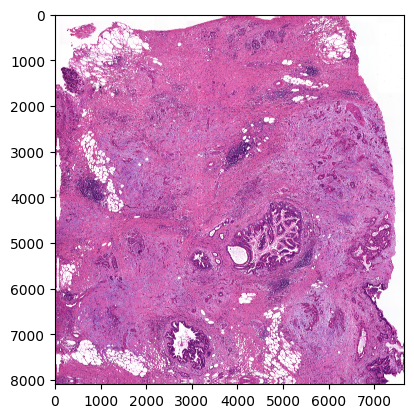

In [17]:
plt.imshow(rearrange(he_img, 'c h w -> h w c'))

In [18]:
assert exp_img.shape[1:] == he_img.shape[1:]

In [19]:
he_context_img = torch.tensor(a.uns['rescaled_he'][f'{scale * context_rescale_factor}X_trimmed'], dtype=torch.uint8)
he_context_img = rearrange(he_context_img, 'h w c -> c h w')
he_context_img = reflection_mosiac(he_context_img, border=border)
he_context_img = TF.convert_image_dtype(he_context_img, dtype=torch.float32)
he_context_img.shape, he_context_img.max()

(torch.Size([3, 2120, 2009]), tensor(1.))

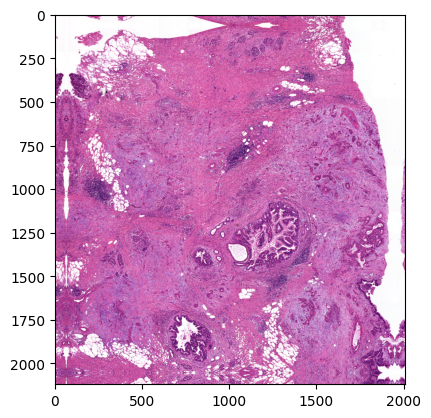

In [20]:
plt.imshow(rearrange(he_context_img, 'c h w -> h w c'))

#### make dataloaders

In [21]:
class HETransform(object):
    def __init__(self, p=.8, brightness=.1, contrast=.1, saturation=.1, hue=.1, sharpness=.3, normalize=True):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.sharpness = sharpness
        
        if normalize:
            self.normalize = Normalize((0.771, 0.651, 0.752), (0.229, 0.288, 0.224)) # from HT397B1-H2 ffpe H&E image
        else:
            self.normalize = nn.Identity()
 
        self.p = p
    
    def apply_color_transforms(self, x, brightness, contrast, saturation, hue, sharpness):
        x = TF.adjust_brightness(x, brightness)
        x = TF.adjust_contrast(x, contrast)
        x = TF.adjust_saturation(x, saturation)
        x = TF.adjust_hue(x, hue)
        x = TF.adjust_sharpness(x, sharpness)
        return x
        
    def __call__(self, he, mask):
        """
        """
        if isinstance(he, torch.Tensor):
            hes = [he]
            masks = [mask]
            return_type = 'image'
        elif isinstance(he, dict):
            keys = list(he.keys())
            hes = [he[k] for k in keys]
            masks = [mask[k] for k in keys]
            return_type = 'dict'
        else:
            hes = he
            masks = mask
            return_type = 'list'
                                
        # we apply transforms with probability p
        if torch.rand(size=(1,)) < self.p:
            brightness, contrast, saturation, hue, sharpness = (
                np.random.uniform(max(0, 1 - self.brightness), 1 + self.brightness, size=1)[0],
                np.random.uniform(max(0, 1 - self.contrast), 1 + self.contrast, size=1)[0],
                np.random.uniform(max(0, 1 - self.saturation), 1 + self.saturation, size=1)[0],
                np.random.uniform(-self.hue, self.hue, size=1)[0],
                np.random.uniform(max(0, 1 - self.sharpness), 1 + self.sharpness, size=1)[0],
            )
            # apply color jitter and sharpness
            hes = [self.apply_color_transforms(x, brightness, contrast, saturation, hue, sharpness)
                   for x in hes]
            
            # vertical and horizontal flips happen with p=.5
            do_hflip, do_vflip = torch.rand(size=(2,)) < .5 
            if do_hflip:
                hes = [TF.hflip(x) for x in hes]
                masks = [TF.hflip(x) for x in masks]
            if do_vflip:
                hes = [TF.vflip(x) for x in hes]
                masks = [TF.vflip(x) for x in masks]
        
        # normalize he
        hes = [self.normalize(x) for x in hes]
                    
        if return_type == 'image':
            return hes[0], masks[0]
        elif return_type == 'dict':
            return {k:v for k, v in zip(keys, hes)}, {k:v for k, v in zip(keys, masks)}
        return hes, masks

In [22]:
def get_tile(img, r, c, tile_size=64):
    r1 = r - tile_size // 2
    c1 = c - tile_size // 2
    return TF.crop(img, r1, c1, height=tile_size, width=tile_size)
    
    return img[:, r1:r2, c1:c2]
    
class MergedDataset(Dataset):
    def __init__(self, he, he_context, exp, exp_context, nuclei_coords,
                 he_transform=None, labels=None, tile_size=64, border=0,
                 context_rescale_factor=4, exp_rescale_factor=1):
        super().__init__()
        self.he = he # (c h w), 0-1.
        self.he_context = he_context
        self.exp = exp # (c h w), 0-1.
        self.exp_context = exp_context
        self.coords = nuclei_coords
        self.tile_size = tile_size
        self.exp_rescale_factor = exp_rescale_factor
        self.context_rescale_factor = context_rescale_factor
        self.border = border
        
        self.he_transform = he_transform
        
        self.labels = labels
        
        if self.labels is not None:
            self.y = F.one_hot(labels).to(torch.float32)

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        
        r, c = self.coords[idx]
        he_tile = get_tile(self.he, r + border, c + border, tile_size=self.tile_size)
        
        context_r, context_c = r // self.context_rescale_factor, c // self.context_rescale_factor
        he_context_tile = get_tile(self.he_context, context_r + border, context_c + border,
                                   tile_size=self.tile_size)
        
        exp_r, exp_c = r // self.exp_rescale_factor, c // self.exp_rescale_factor
        exp_tile = get_tile(self.exp, exp_r + border, exp_c + border, tile_size=self.tile_size)
        
        offset = self.exp_rescale_factor * self.context_rescale_factor
        context_r, context_c = r // offset, c // offset
        exp_context_tile = get_tile(self.exp_context, context_r + border, context_c + border, tile_size=self.tile_size)
        
        if self.he_transform is not None:
            hes = [he_tile, he_context_tile]
            exps = [exp_tile, exp_context_tile]
            (he_tile, he_context_tile), (exp_tile, exp_context_tile) = self.he_transform(hes, exps)

        return {
            'he': he_tile,
            'he_context': he_context_tile,
            'exp': exp_tile,
            'exp_context': exp_context_tile,
            'y': torch.tensor([0]) if self.labels is None else self.y[idx],
            'r': r,
            'c': c
        }

In [23]:
train_he_transform = HETransform(p=.95, brightness=.1, contrast=.1, saturation=.1, hue=.1, normalize=True)
val_he_transform = HETransform(p=0.0, normalize=True)

In [24]:
tile_size = 64

In [25]:
train_ds = MergedDataset(
    he_img, he_context_img, exp_img, exp_context_img, coord_df[['row', 'col']].values, tile_size=tile_size,
    he_transform=train_he_transform, labels=torch.tensor(coord_df['label_idx'].to_numpy()),
    exp_rescale_factor=exp_rescale_factor, context_rescale_factor=context_rescale_factor,
    border=border
)
len(train_ds)

1582

In [26]:
val_ds = MergedDataset(
    he_img, he_context_img, exp_img, exp_context_img, coord_df[['row', 'col']].values, tile_size=tile_size,
    he_transform=val_he_transform, labels=torch.tensor(coord_df['label_idx'].to_numpy()),
    exp_rescale_factor=exp_rescale_factor, context_rescale_factor=context_rescale_factor, border=border
)
len(val_ds)

1582

In [27]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=20)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=20)

In [28]:
%%time
batch = next(iter(train_dl))

CPU times: user 2.28 s, sys: 1.79 s, total: 4.08 s
Wall time: 3.84 s


In [29]:
batch['he'].shape, batch['exp'].shape, batch['y'].shape

(torch.Size([32, 3, 64, 64]),
 torch.Size([32, 12, 64, 64]),
 torch.Size([32, 6]))

###### inspect batch

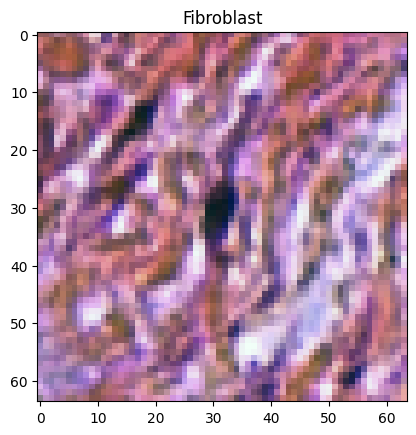

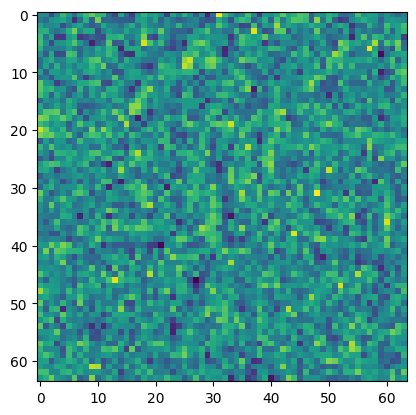

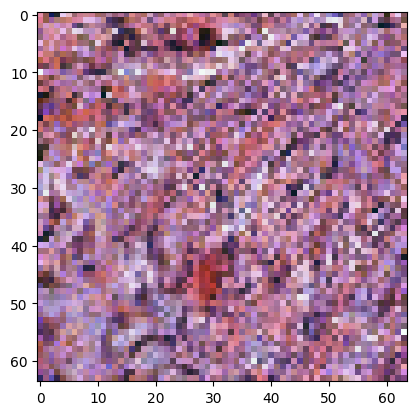

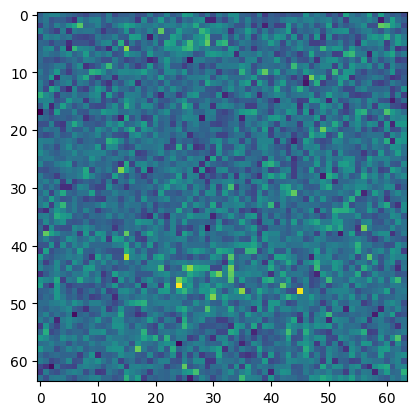

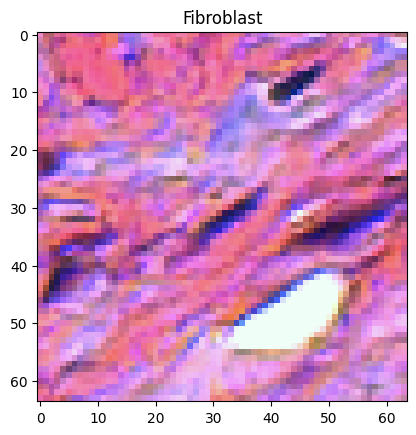

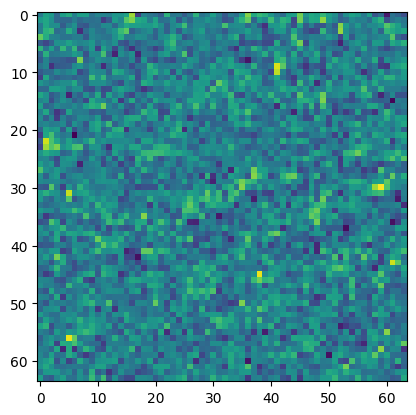

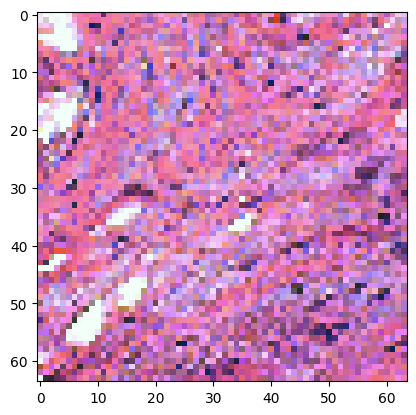

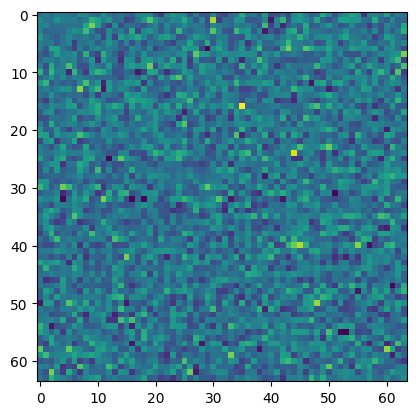

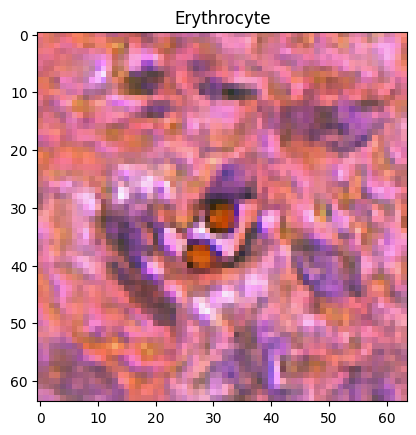

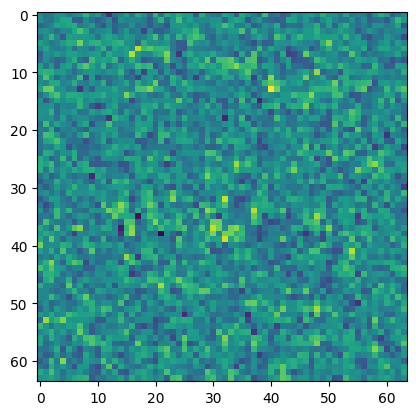

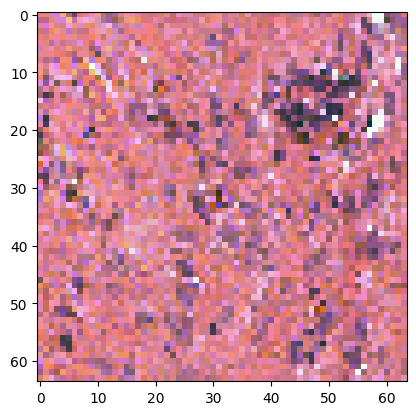

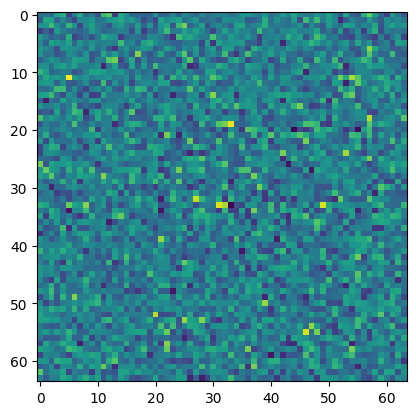

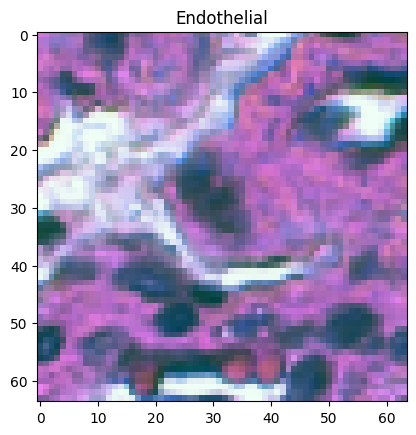

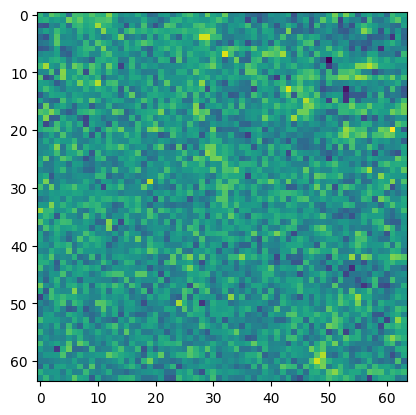

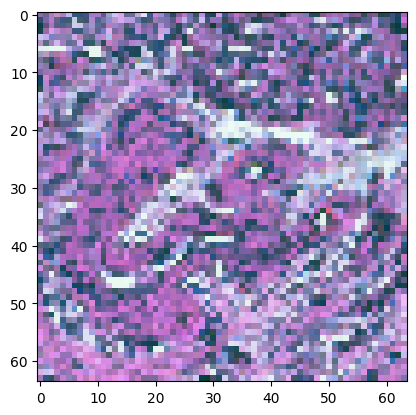

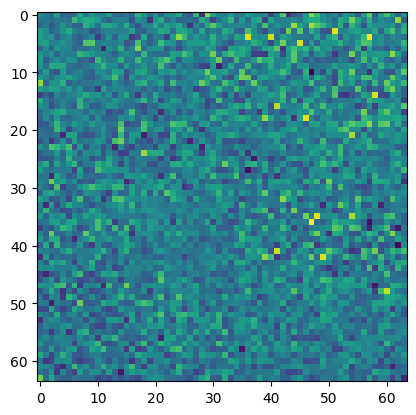

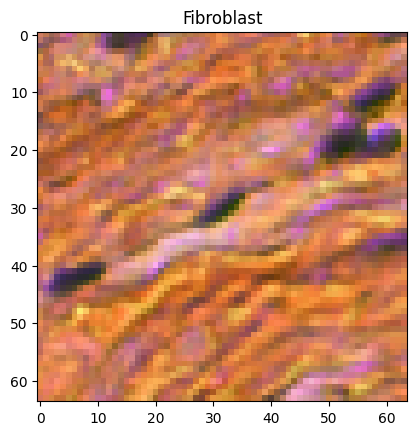

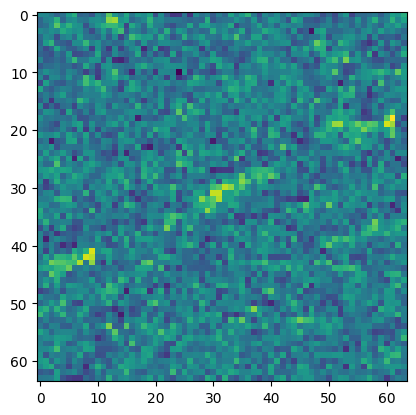

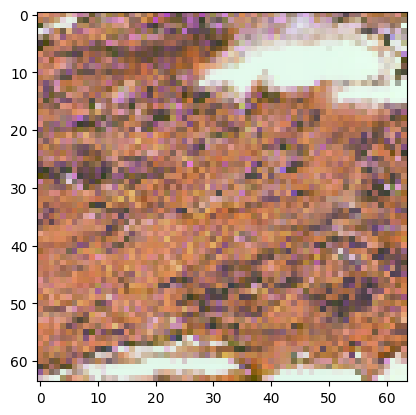

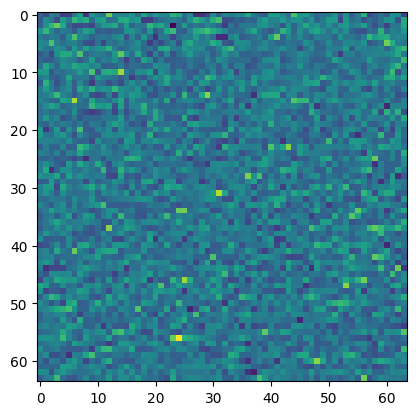

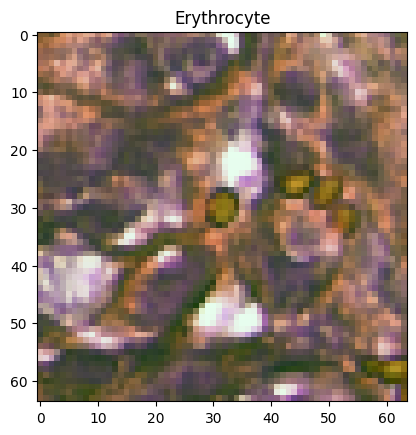

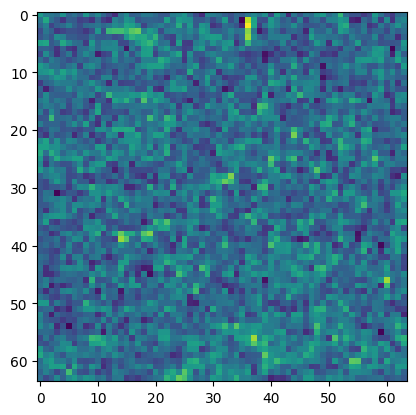

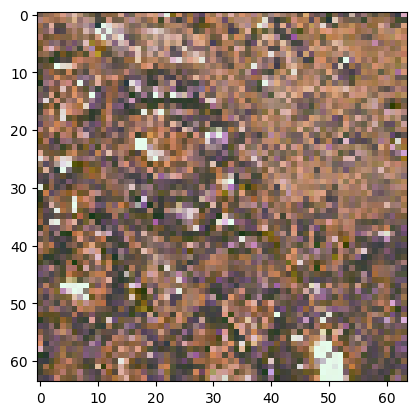

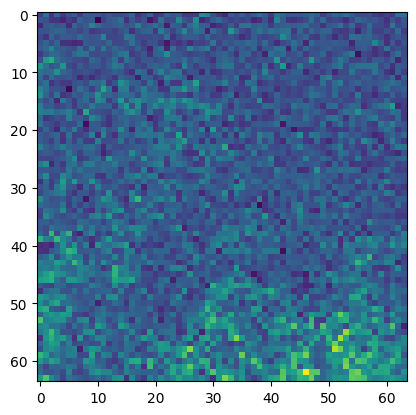

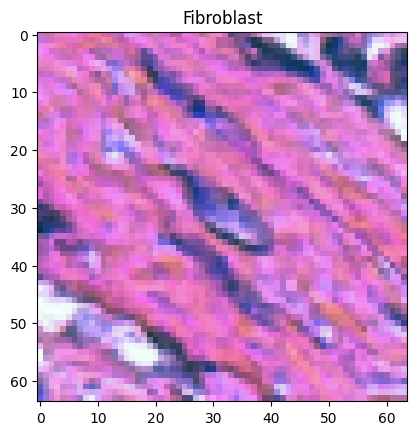

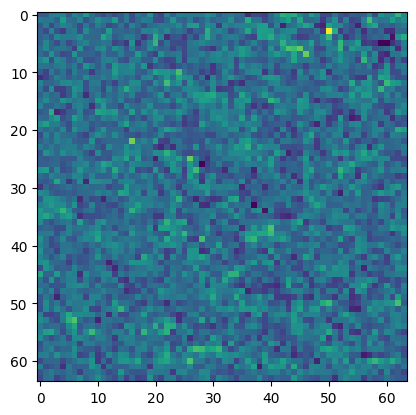

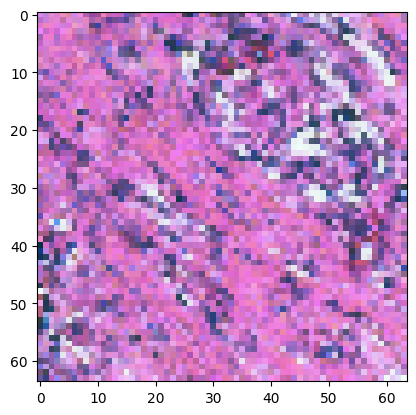

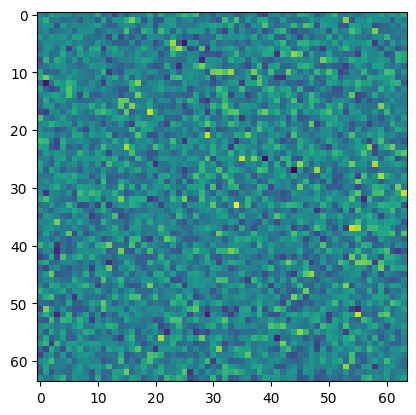

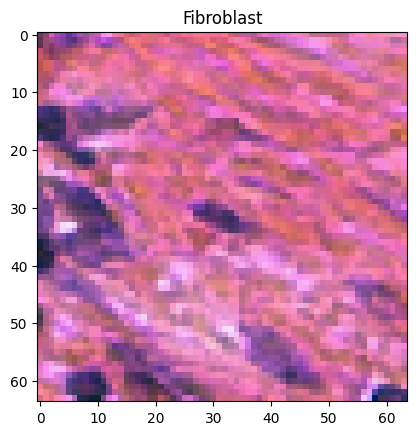

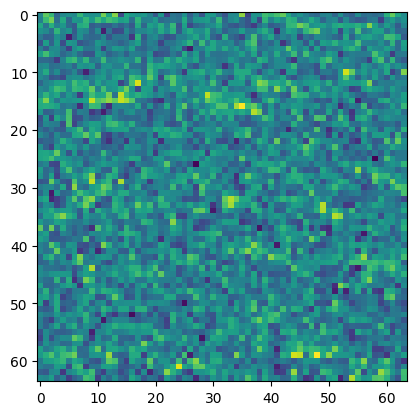

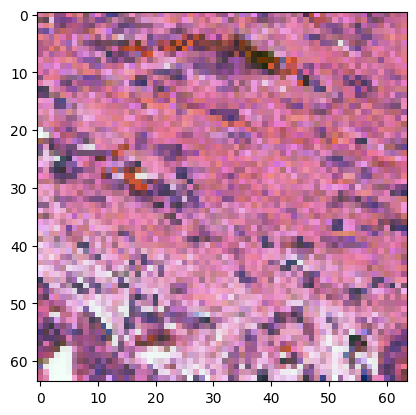

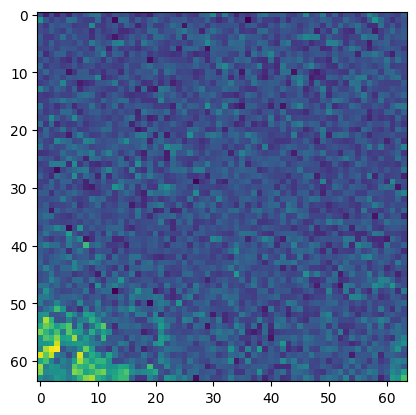

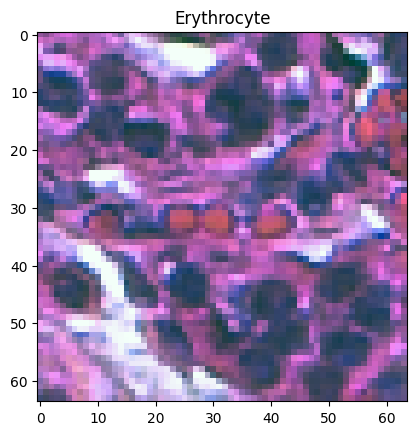

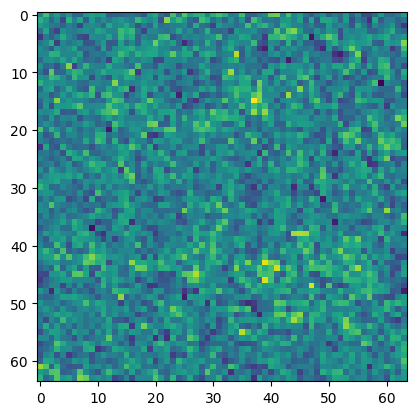

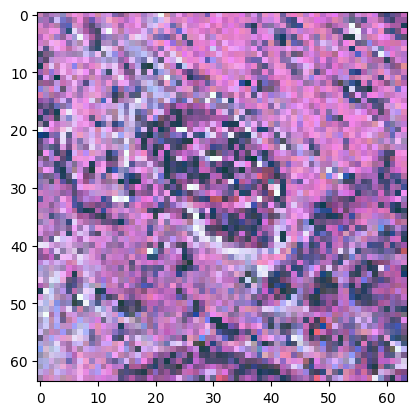

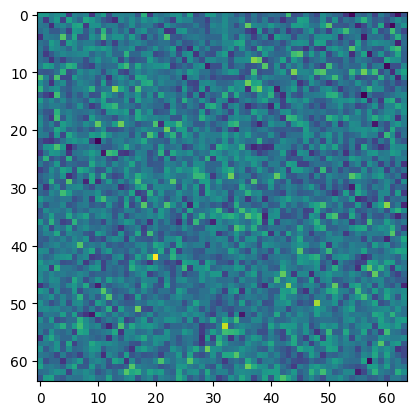

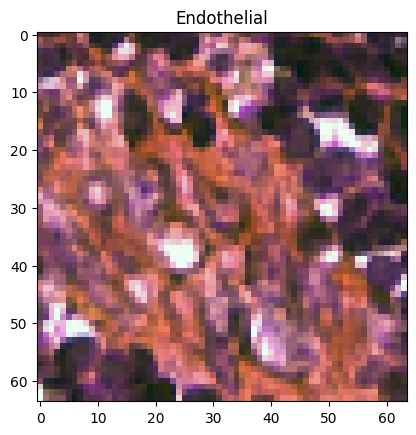

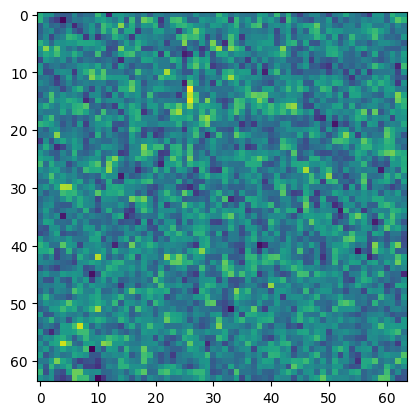

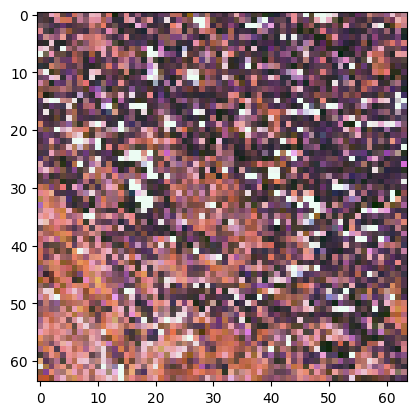

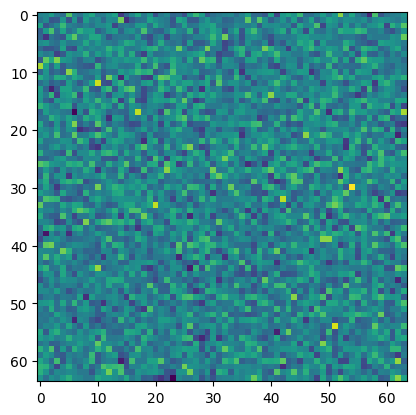

In [41]:
for i in range(10):
    img = rearrange(batch['he'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img)
    plt.title(labels[batch['y'][i].argmax()])
    plt.show()
    
    img = rearrange(batch['exp'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img[:, :, list(exp_genes).index('KRT18')])
    plt.show()
    
    img = rearrange(batch['he_context'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img)
    plt.show()
    
    img = rearrange(batch['exp_context'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img[:, :, list(exp_genes).index('KRT18')])
    plt.show()

#### model

In [30]:
class CellClassifier(nn.Module):
    def __init__(self, tile_size, n_exp_channels, n_classes, n_latent=1000):
        super().__init__()
        
        self.tile_size = tile_size
        self.n_classes = n_classes
        self.n_latent = n_latent
        self.n_exp_channels = n_exp_channels
        
        self.encode_he = create_model('resnet18', num_classes=self.n_latent, in_chans=3)
        self.encode_he_context = create_model('resnet18', num_classes=self.n_latent, in_chans=3)
        self.encode_exp = create_model('resnet18', num_classes=self.n_latent, in_chans=self.n_exp_channels)
        self.encode_exp_context = create_model('resnet18', num_classes=self.n_latent, in_chans=self.n_exp_channels)
            
        self.prediction_head = nn.Sequential(
            nn.Linear(self.n_latent, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(128, self.n_classes),
            nn.Softmax(dim=-1)
        )
        
        self.loss = nn.CrossEntropyLoss()
        
    def calculate_loss(self, y_pred, y_true):
        return self.loss(y_pred, y_true)
    
    def forward(self, he_tile, he_context_tile, exp_tile, exp_context_tile):
        he_z = self.encode_he(he_tile)
        he_context_z = self.encode_he_context(he_context_tile)
        exp_z = self.encode_exp(exp_tile)
        exp_context_z = self.encode_exp_context(exp_context_tile)
        
        z = he_z + he_context_z + exp_z + exp_context_z
        
        probs = self.prediction_head(z)
        
        return probs

In [31]:
def log_intermediates(logger, batch, plot_genes,
                      y_pred, y_true,
                      n_samples=8, identifier='train'):
    model_genes = np.asarray(exp_genes)
    g2i = {g:i for i, g in enumerate(model_genes)}
    gene_idxs = np.asarray([g2i[g] for g in plot_genes])
    
    img = batch['he'][:n_samples].clone().detach()
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key=f"{identifier}/he",
        images=[img],
        caption=[f'{identifier} he']
    )
    
    img = batch['he_context'][:n_samples].clone().detach()
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key=f"{identifier}/he_context",
        images=[img],
        caption=[f'{identifier} he context']
    )

    recon = batch['exp'][:n_samples].clone().detach().to(torch.float16)
    recon = recon[:, gene_idxs, :, :]
    recon -= recon.min()
    recon /= recon.max()
    recon = rearrange(recon, 'b c h w -> c b 1 h w')
    logger.log_image(
        key=f"{identifier}/exp",
        images=[img for img in recon],
        caption=[g for g in plot_genes]
    )
    
    recon = batch['exp_context'][:n_samples].clone().detach().to(torch.float16)
    recon = recon[:, gene_idxs, :, :]
    recon -= recon.min()
    recon /= recon.max()
    recon = rearrange(recon, 'b c h w -> c b 1 h w')
    logger.log_image(
        key=f"{identifier}/exp_context",
        images=[img for img in recon],
        caption=[g for g in plot_genes]
    )
    
    img = y_pred.clone().detach().cpu().numpy()[:n_samples]
    df = pd.DataFrame(data=img, columns=labels)
    logger.log_text(
        key=f'{identifier}/probs',
        dataframe=df,
    )
    
    img = y_pred.clone().detach().cpu().numpy()[:n_samples]
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key=f'{identifier}/probs_df',
        images=[img],
        caption=['probs']
    )
    
    img = y_true.clone().detach().cpu().numpy()[:n_samples]
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key=f'{identifier}/true',
        images=[img],
        caption=['true']
    )
    

In [32]:
class CellClassifierLightning(pl.LightningModule):
    def __init__(self, model, lr=1e-3, n_samples=16, plot_genes=['IL7R', 'KRT18', 'BGN', 'PECAM1', 'INS'],
                 train_epoch_fraction=.1):
        super().__init__()
        
        self.model = model
        self.lr = lr
        self.plot_genes = plot_genes
        self.n_samples = n_samples
        self.train_epoch_fraction = train_epoch_fraction
        
        self.save_hyperparameters(ignore=['model'])

    def training_step(self, batch, batch_idx):
        he, he_context, exp, exp_context, y = batch['he'], batch['he_context'], batch['exp'], batch['exp_context'], batch['y']
        probs = self.model(he, he_context, exp, exp_context)
        loss = self.model.calculate_loss(probs, y)
        self.log_dict({'train/loss': loss}, on_step=False, on_epoch=True, prog_bar=True)

        # only log % of training epochs
        if batch_idx == 0 and torch.rand(1).item() < self.train_epoch_fraction:
            log_intermediates(self.logger, batch, self.plot_genes,
                              probs, y,
                              n_samples=self.n_samples, identifier='train')
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        he, he_context, exp, exp_context, y = batch['he'], batch['he_context'], batch['exp'], batch['exp_context'], batch['y']
        probs = self.model(he, he_context, exp, exp_context)
        loss = self.model.calculate_loss(probs, y)
        self.log_dict({'val/loss': loss}, on_step=False, on_epoch=True, prog_bar=True)
        
        if batch_idx == 0:
            log_intermediates(self.logger, batch, self.plot_genes,
                              probs, y,
                              n_samples=self.n_samples, identifier='val')
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

#### training

In [33]:
project = 'cell_classifier'
log_dir = '/scratch1/fs1/dinglab/estorrs/deep-spatial-genomics/logs'

In [34]:
from pytorch_lightning.loggers import WandbLogger
logger = WandbLogger(project=project, save_dir=log_dir)

In [35]:
# wandb.finish()

In [36]:
config = {
    'n_exp_channels': len(exp_genes),
    'exp_channels': exp_genes,
    'tile_size': tile_size,
    'labels': labels,
    'n_labels': len(labels),
    'latent_dim': 256,
    'he_scale': '2X',
    'context_rescale_factor': context_rescale_factor,
    'exp_rescale_factor': exp_rescale_factor,
    'he_encoder': {
        'model': 'resnet18',
        'in_channels': 3,
    },
    'he_context_encoder': {
        'model': 'resnet18',
        'in_channels': 3,
    },
    'exp_encoder': {
        'model': 'resnet18',
        'in_channels': len(exp_genes),
    },
    'exp_context_encoder': {
        'model': 'resnet18',
        'in_channels': len(exp_genes),
    },
    'training': {
        'train_samples': ['a'],
        'val_samples': ['a'],
        'log_n_samples': 8,
        'max_epochs': 15,
        'check_val_every_n_epoch': 1,
        'log_train_fraction': 1.,
        'log_every_n_steps': 1,
        'accelerator': 'gpu',
        'devices': 1,
        'limit_train_batches': 1.,
        'limit_val_batches': 1.,
        'lr': 1e-3,
        'batch_size': batch_size,
        'precision': 32
    },
}
logger.experiment.config.update(config)

In [37]:
cc = CellClassifier(
    config['tile_size'],
    config['n_exp_channels'],
    config['n_labels'],
    n_latent=config['latent_dim']
)
model = CellClassifierLightning(
    cc, lr=config['training']['lr'],
    n_samples=config['training']['log_n_samples'],
    train_epoch_fraction=config['training']['log_train_fraction'],
    plot_genes=config['exp_channels']
)

In [38]:
trainer = pl.Trainer(
    devices=config['training']['devices'],
    accelerator=config['training']['accelerator'],
    check_val_every_n_epoch=config['training']['check_val_every_n_epoch'],
    enable_checkpointing=False,
    limit_val_batches=config['training']['limit_val_batches'],
    limit_train_batches=config['training']['limit_train_batches'],
    log_every_n_steps=config['training']['log_every_n_steps'],
    max_epochs=config['training']['max_epochs'],
    precision=config['training']['precision'],
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


In [39]:
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type           | Params
-----------------------------------------
0 | model | CellClassifier | 45.3 M
-----------------------------------------
45.3 M    Trainable params
0         Non-trainable params
45.3 M    Total params
181.354   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


###### predict slide

In [40]:
data = []
for r, c in a.uns['segmented_nuclei_coords_1X_trimmed'].to_numpy():
    data.append([r // scale, c // scale, 'unknown', 0])
pred_coord_df = pd.DataFrame(data=data, columns=['row', 'col', 'label', 'label_idx'])
pred_coord_df

row   col    label  label_idx
0       4688  4860  unknown          0
1       2243  5527  unknown          0
2       2240  1435  unknown          0
3       3334  3632  unknown          0
4       2344  1318  unknown          0
...      ...   ...      ...        ...
120252  6731  1244  unknown          0
120253  2445  4233  unknown          0
120254  7330  4072  unknown          0
120255  3521  1641  unknown          0
120256  6048  4779  unknown          0

[120257 rows x 4 columns]

In [41]:
# filter for middle
# mask = (pred_coord_df['row'] >= 512) & (he_img.shape[1] - pred_coord_df['row'] >= 512)
# pred_coord_df = pred_coord_df[mask]

# mask = (pred_coord_df['col'] >= 512) & (he_img.shape[2] - pred_coord_df['col'] >= 512)
# pred_coord_df = pred_coord_df[mask]

# pred_coord_df

In [42]:
pred_ds = MergedDataset(
    he_img, he_context_img, exp_img, exp_context_img, pred_coord_df[['row', 'col']].values, tile_size=tile_size,
    he_transform=val_he_transform, border=border,
    exp_rescale_factor=exp_rescale_factor, context_rescale_factor=context_rescale_factor
)
len(pred_ds)

120257

###### inspect batch

In [ ]:
%%time
batch = next(iter(pred_dl))

In [ ]:
for i in range(10):
    img = rearrange(batch['he'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img)
    plt.show()
    
    img = rearrange(batch['exp'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img[:, :, exp_genes.index('KRT18')])
    plt.show()
    
    img = rearrange(batch['he_context'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img)
    plt.show()
    
    img = rearrange(batch['exp_context'][i], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    plt.imshow(img[:, :, exp_genes.index('KRT18')])
    plt.show()

#### predict dataset

In [43]:
bs = 128
pred_dl = DataLoader(pred_ds, batch_size=bs, shuffle=False, num_workers=20)

In [44]:
# %%time
data = []

m = model.model
m = m.cuda()
m.eval()
with torch.no_grad():
    for j, batch in enumerate(pred_dl):
        if j % 10 == 0:
            print(j * bs)
        he, he_context, exp, exp_context, y, r, c = batch['he'], batch['he_context'], batch['exp'], batch['exp_context'], batch['y'], batch['r'], batch['c']
        y, r, c = y.clone().detach().numpy(), r.clone().detach().numpy(), c.clone().detach().numpy()

        if next(iter(model.parameters())).is_cuda:
            he, he_context, exp, exp_context = he.cuda(), he_context.cuda(), exp.cuda(), exp_context.cuda()
        probs = m(he, he_context, exp, exp_context).clone().detach().cpu().numpy()
        idxs = probs.argmax(axis=-1)
        pred_labels = [labels[i] for i in idxs]
        idxs = y.argmax(axis=-1)
        true_labels = [labels[i] for i in idxs]
        
        for i in range(probs.shape[0]):
            row = list(probs[i])
            row += [pred_labels[i], true_labels[i], r[i], c[i]]
            data.append(row)
cols = list(labels)
cols += ['predicted', 'true', 'row', 'col']
df = pd.DataFrame(data, columns=cols)
df

0
1280
2560
3840
5120
6400
7680
8960
10240
11520
12800
14080
15360
16640
17920
19200
20480
21760
23040
24320
25600
26880
28160
29440
30720
32000
33280
34560
35840
37120
38400
39680
40960
42240
43520
44800
46080
47360
48640
49920
51200
52480
53760
55040
56320
57600
58880
60160
61440
62720
64000
65280
66560
67840
69120
70400
71680
72960
74240
75520
76800
78080
79360
80640
81920
83200
84480
85760
87040
88320
89600
90880
92160
93440
94720
96000
97280
98560
99840
101120
102400
103680
104960
106240
107520
108800
110080
111360
112640
113920
115200
116480
117760
119040


Endothelial    Epithelial   Erythrocyte    Fibroblast  Immune cells  \
0       1.459106e-05  9.393041e-03  8.442775e-05  1.912132e-05  9.904722e-01   
1       1.286556e-06  9.999942e-01  1.668822e-06  6.627564e-07  7.382070e-07   
2       3.811784e-06  9.657376e-06  9.786689e-07  7.277374e-07  8.595992e-05   
3       4.541481e-01  3.849220e-02  2.138653e-03  7.909026e-04  5.006049e-01   
4       6.677240e-08  2.134994e-07  3.485628e-07  5.592672e-07  9.999986e-01   
...              ...           ...           ...           ...           ...   
120252  7.245188e-01  7.157057e-04  5.699879e-03  2.655449e-01  3.001817e-03   
120253  3.761877e-05  4.356687e-06  9.434215e-05  9.998330e-01  2.205472e-05   
120254  1.966287e-05  1.306371e-06  3.378908e-05  9.999324e-01  1.078220e-05   
120255  2.496567e-03  3.181318e-05  1.325857e-03  9.960854e-01  4.157468e-05   
120256  9.802567e-01  9.139454e-05  2.867555e-04  1.903615e-02  2.778087e-04   

               Islet     predicted         true   row   col  
0       1.660074e-05  Immune cells  Endothelial  4688  4860  
1       1.401087e-06    Epithelial  Endothelial  2243  5527  
2       9.998989e-01         Islet  Endothelial  2240  1435  
3       3.825224e-03  Immune cells  Endothelial  3334  3632  
4       2.010540e-07  Immune cells  Endothelial  2344  1318  
...              ...           ...          ...   ...   ...  
120252  5.188940e-04   Endothelial  Endothelial  6731  1244  
120253  8.581480e-06    Fibroblast  Endothelial  2445  4233  
120254  2.034111e-06    Fibroblast  Endothelial  7330  4072  
120255  1.881309e-05    Fibroblast  Endothelial  3521  1641  
120256  5.118727e-05   Endothelial  Endothelial  6048  4779  

[120257 rows x 10 columns]

In [45]:
# from sklearn.metrics import f1_score
# f1_score(df['predicted'], df['true'], average='macro')

In [46]:
# # %%time
# data = []
# model.eval()
# with torch.no_grad():
#     for j, batch in enumerate(pred_dl):
#         if j % 10 == 0:
#             print(j * 512)
#         he, he_context, exp, exp_context, y, r, c = batch['he'], batch['he_context'], batch['exp'], batch['exp_context'], batch['y'], batch['r'], batch['c']
#         y, r, c = y.clone().detach().numpy(), r.clone().detach().numpy(), c.clone().detach().numpy()
#         if next(iter(model.parameters())).is_cuda:
#             he, he_context, exp, exp_context = he.cuda(), he_context.cuda(), exp.cuda(), exp_context.cuda()
#         probs = model.model(he, he_context, exp, exp_context).clone().detach().cpu().numpy()
#         idxs = probs.argmax(axis=-1)
#         pred_labels = [labels[i] for i in idxs]
#         idxs = y.argmax(axis=-1)
#         true_labels = [labels[i] for i in idxs]
        
#         for i in range(probs.shape[0]):
#             row = list(probs[i])
#             row += [pred_labels[i], true_labels[i], r[i], c[i]]
#             data.append(row)
# cols = list(labels)
# cols += ['predicted', 'true', 'row', 'col']
# df = pd.DataFrame(data, columns=cols)
# df

In [47]:
# x = rearrange(he_img, 'c h w -> h w c')
# for r, c, l in list(zip(df['row'], df['col'], df['predicted']))[:10]:
#     r, c = r + border, c + border
#     r1, r2 = r - 32, r + 32
#     c1, c2 = c - 32, c + 32
#     plt.imshow(x[r1:r2, c1:c2])
#     plt.title(l)
#     plt.show()

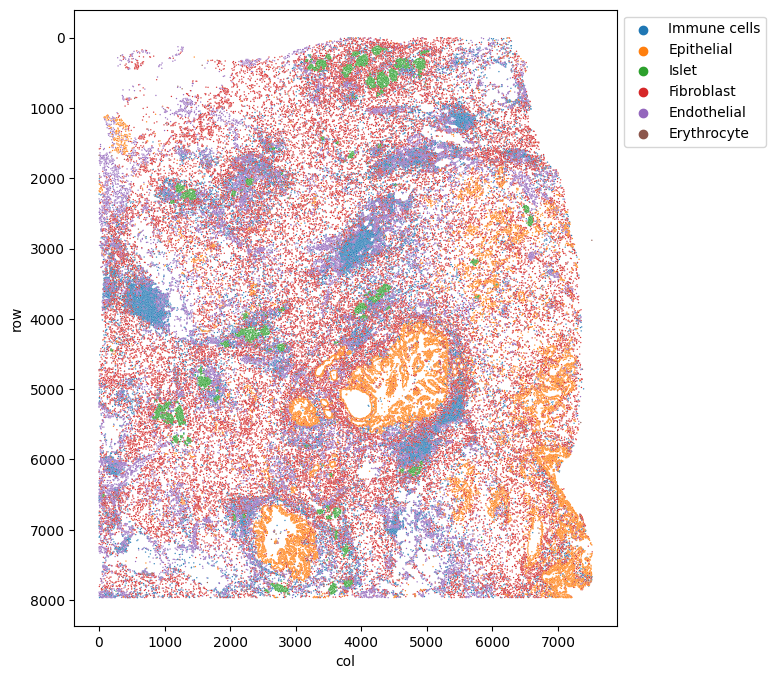

In [49]:
import seaborn as sns
mr, mc = he_img.shape[2] // 1000, he_img.shape[1] // 1000
fig, ax = plt.subplots(figsize=(mr, mc))
sns.scatterplot(data=df, x='col', y='row', hue='predicted', s=1, ax=ax)
ax.invert_yaxis()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [50]:
cr1, cc1 = 3500, 4200
cr2, cc2 = cr1 + 1000, cc1 + 1000

/tmp/415074.tmpdir/ipykernel_206834/3754144315.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f = f[((df['col']>cc1) & (df['col'] < cc2))]


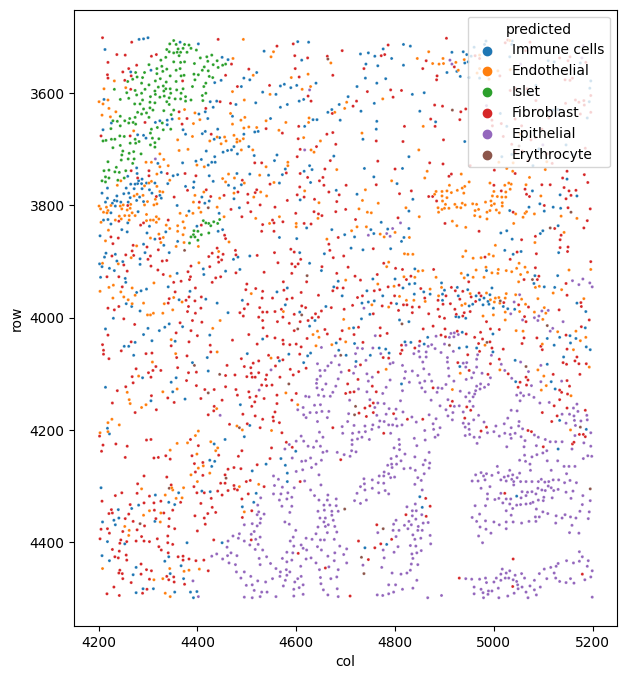

In [51]:
f = df.copy()
f = f[((df['row']>cr1) & (df['row'] < cr2))]
f = f[((df['col']>cc1) & (df['col'] < cc2))]
fig, ax = plt.subplots(figsize=(mr, mc))
sns.scatterplot(data=f, x='col', y='row', hue='predicted', s=5, ax=ax)
ax.invert_yaxis()

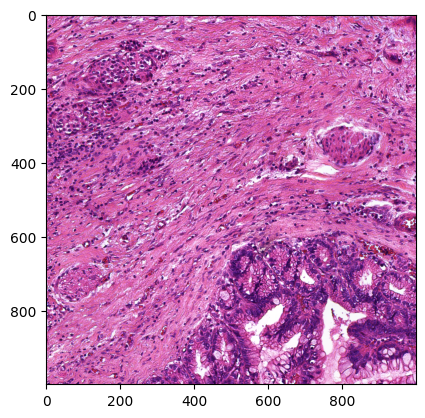

In [52]:
plt.imshow(rearrange(he_img, 'c h w -> h w c')[cr1:cr2, cc1:cc2])

In [53]:
cr1, cc1 = 5500, 5800
cr2, cc2 = cr1 + 500, cc1 + 500

/tmp/415074.tmpdir/ipykernel_206834/1114154572.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f = f[((df['col']>cc1) & (df['col'] < cc2))]


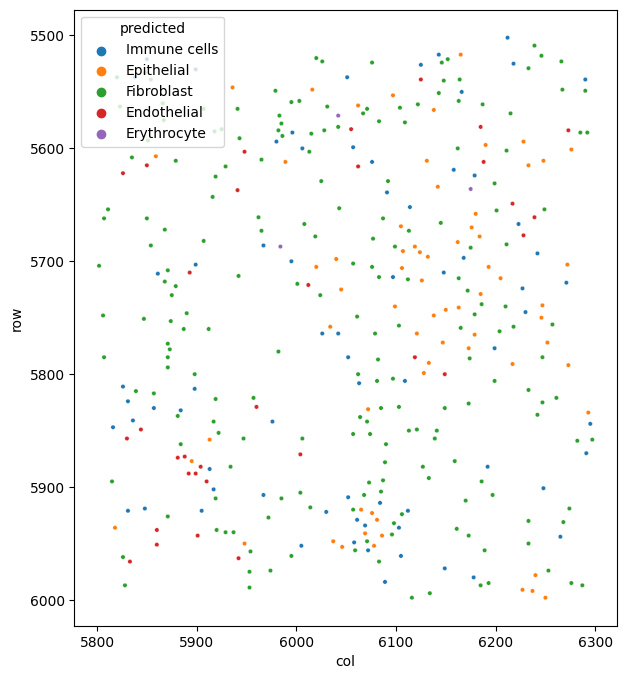

In [54]:
f = df.copy()
f = f[((df['row']>cr1) & (df['row'] < cr2))]
f = f[((df['col']>cc1) & (df['col'] < cc2))]
fig, ax = plt.subplots(figsize=(mr, mc))
sns.scatterplot(data=f, x='col', y='row', hue='predicted', s=10, ax=ax)
ax.invert_yaxis()

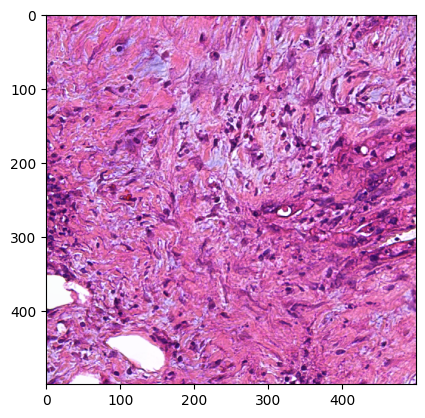

In [55]:
plt.imshow(rearrange(he_img, 'c h w -> h w c')[cr1:cr2, cc1:cc2])

In [ ]:
plt.imshow(rearrange(exp, 'c h w -> h w c')[cr1:cr2, cc1:cc2])

In [ ]:
plt.imshow(exp_img[exp_genes.index('KRT18'), cr1:cr2, cc1:cc2])

In [ ]:
cr1, cc1 = 5000, 3800
cr2, cc2 = cr1 + 1000, cc1 + 1000

In [ ]:
f = df.copy()
f = f[((df['row']>cr1) & (df['row'] < cr2))]
f = f[((df['col']>cc1) & (df['col'] < cc2))]
fig, ax = plt.subplots(figsize=(mr, mc))
sns.scatterplot(data=f, x='col', y='row', hue='predicted', s=10, ax=ax)
ax.invert_yaxis()

In [ ]:
plt.imshow(rearrange(he_img, 'c h w -> h w c')[cr1:cr2, cc1:cc2])

In [ ]:
plt.imshow(exp_img[exp_genes.index('KRT18'), cr1:cr2, cc1:cc2])